# LAB MEETING
### 11-20-2020

### An unmet need in the lab: implement closed-loop system for deepLabCut
- **Robyn:** 
    - Detect grooming and stimulate with low latency
    - Try to mess with transition probabilities between behaviors? 
- **Tony:**
    - Stimulate during locmotion at precise phase of gait
- **Didi:** 
    - Stimulate during peak acceleration towards reward port

# <div align="center"> 

### Latest version: DeepLabCut Live! (Kane et al., 2020, Biorxiv)
<img src="./lab_meetings/201120/bonsai_DLC.png" width="500">


- **~15ms latency at >100fps on GPUs and ~30ms latency on CPUs**
- **Foward prediction modeling (kalman filtering) achieves zero-latency (or negative)!**
- **Can plug into any experimental setup (they use Bonsai as an example)**

### Grooming extraction:

In [3]:
import moviepy.editor as mpy
fps = 70
frame_st = 46000
frame_ed = 46500
clip = mpy.VideoFileClip("./RS07082020b_08182020.mp4")
clip = clip.subclip(frame_st/fps,frame_ed/fps).resize(height=360)
clip.ipython_display(loop=1)

t:   3%|▎         | 13/501 [00:00<00:03, 122.75it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Exploratory Analyses:

In [4]:
import pandas as pd
import numpy as np
import os

In [13]:
# Helper functions to extract hand-scored grooming data:
def find(name, path): # returns filepath
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

def get_grooming_labels(DLC_file,label_file): # returns grooming labels for each frame
    results = dict()
    df_DLC = pd.read_csv(find(DLC_file,'./'),header=[0,1,2],low_memory=False)
    df_label = pd.read_csv(find(label_file,'./'),low_memory=False)
    labels = np.zeros([df_DLC.shape[0],1])
    bout_length = []
    for bout in range(df_label.shape[0]):
        labels[df_label['start frame'][bout]:df_label['end frame'][bout]] = 1    
        bout_length.append(df_label['bout_dur'][bout])
        
    results['labels'] = labels
    results['bout_length'] = np.array(bout_length)
    return results

### Plot basic grooming statistics (5 manually-scored videos):

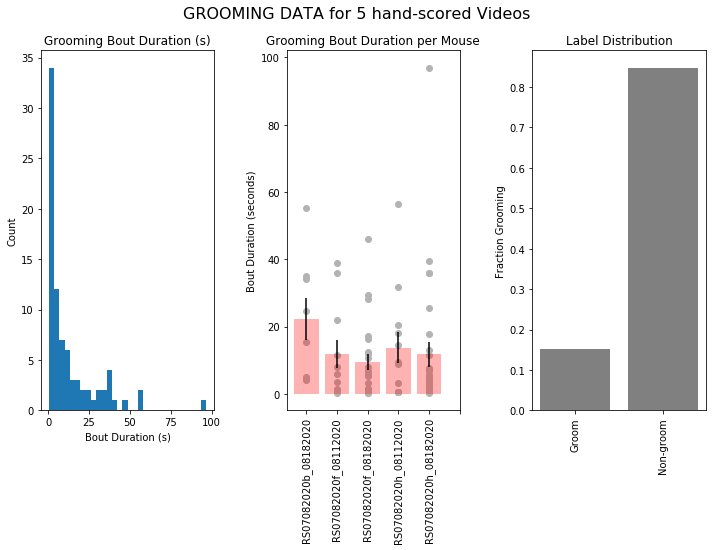

In [14]:
import matplotlib.pyplot as plt

# 5 hand-scored recording sessions:
filenames = ['RS07082020b_08182020',
             'RS07082020f_08112020',
             'RS07082020f_08182020',
             'RS07082020h_08112020',
             'RS07082020h_08182020']

fig,ax = plt.subplots(1,3,figsize=(10,8))
fps = 70
av_bout_len = []
err = []
bout_len = []
all_labels = []

for fNum,file in enumerate(filenames):
    results = get_grooming_labels(f"{file}_DLC.csv",f"{file}_label.csv")
    bout_len.extend(results['bout_length']/fps)
    av_bout_len.append(np.mean(results['bout_length']/fps))
    all_labels.append(np.mean(results['labels']))
    err.append(np.std(results['bout_length']/fps)/np.sqrt(len(results['bout_length'])))
    ax[1].scatter(np.ones(len(results['bout_length']))*fNum,results['bout_length']/fps,color=[.7,.7,.7])


ax[0].set_title('Grooming Bout Duration (s)')
ax[0].hist(bout_len,bins=30)
ax[0].set_xlabel('Bout Duration (s)')
ax[0].set_ylabel('Count')
ax[1].bar(range(len(filenames)),av_bout_len,alpha=.3,color=[1,0,0],yerr=err)
ax[1].set_ylabel('Bout Duration (seconds)')
ax[1].set_xticks(range(6))
ax[1].set_xticklabels(filenames,rotation='vertical')
ax[1].set_title('Grooming Bout Duration per Mouse')
ax[2].bar(range(2),[np.mean(all_labels), 1-np.mean(all_labels)],color=[.5,.5,.5])
ax[2].set_ylabel('Fraction Grooming')
ax[2].set_xticks(range(2))
ax[2].set_xticklabels(['Groom','Non-groom'],rotation='vertical')
ax[2].set_title('Label Distribution')
fig = plt.gcf()
fig.suptitle("GROOMING DATA for 5 hand-scored Videos", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

- **Grooming events make up roughly 15% of the total number of frames**

# 4. DEFINE FEATURES:

### Features that might predict grooming: (N=10)
- Snout to tail length (ST)
- Snout to front paws length (SF)
- Snout to back paws length (SB)
- Front Paw - Back Paw Velocity (FBV)
- Velocities of each body part (Snout, front paws, back paws, base of tail)

In [15]:
# Feature extraction:
def get_ST_length(df_x,df_y): # Nose-tail length
    ST = ((np.array(df_x['nose'])-np.array(df_x['tail']))**2 + 
        (np.array(df_y['nose'])-np.array(df_y['tail']))**2)**0.5
    return ST
    
def get_SF_length(df_x,df_y): # Nose to Front-paw length
    front_paws_x = (np.array(df_x['pawFR'])+np.array(df_x['pawFL']))/2
    front_paws_y = (np.array(df_y['pawFR'])+np.array(df_y['pawFL']))/2
    FT = ((front_paws_x-np.array(df_x['tail'])**2 + 
        front_paws_y-np.array(df_y['tail']))**2)**0.5
    SF = get_ST_length(df_x,df_y)-FT
    return SF

def get_SB_length(df_x,df_y): # Nose to Back-paw length
    back_paws_x = (np.array(df_x['pawBR'])+np.array(df_x['pawBL']))/2
    back_paws_y = (np.array(df_y['pawBR'])+np.array(df_y['pawBL']))/2
    BT = ((back_paws_x-np.array(df_x['tail']))**2 + 
        (back_paws_y-np.array(df_y['tail']))**2)**0.5
    SB = get_ST_length(df_x,df_y)-BT
    return SB

def get_FBV(df_disp):
    FV = (np.array(df_disp['pawFR'])+np.array(df_disp['pawFL']))/2
    BV = (np.array(df_disp['pawBR'])+np.array(df_disp['pawBL']))/2
    FBV = FV-BV
    return FBV

# 5. Train baseline models:
- **Logistic Regression and Random Forest**

In [25]:
from DataCleaner import *

In [26]:
# Build training and test sets from list of files
def build_model(file_list):
    """
    Input list of files to build feature matrix and labels
    """
    num_col = 10 # change when I play with adding features
    X = np.empty((0,num_col))
    y = np.empty((0,1))
    for fNum,file in enumerate(file_list):
        DLC_file = f"{file}_DLC.csv"
        label_file = f"{file}_label.csv"
        D = DataCleaner(find(DLC_file,'./'))
        D.remove_low_likelihood(.1) # Remove any label with confidence < 10%
        D.remove_jumps(40) # Remove any jumps creater than 40 pixels
        D.interpolate()
        train_df = pd.DataFrame(D.disp)
        train_df['ST'] = get_ST_length(D.x,D.y)
        train_df['SF'] = get_SF_length(D.x,D.y)
        train_df['SB'] = get_SB_length(D.x,D.y)
        train_df['FBV'] = get_FBV(D.disp)
        train_df = (train_df-train_df.mean())/train_df.std()# standardize
        results = get_grooming_labels(DLC_file,label_file)
        train_df['groom'] = results['labels']
        train_df.dropna(inplace=True) # drop nan frames   
        X = np.append(X,train_df.drop('groom', axis=1).to_numpy(),axis=0)
        y = np.append(y,train_df['groom'].to_numpy())
    return X,y
    

In [29]:
# Create training and test groups: 
training_set = ['RS07082020f_08112020',
               'RS07082020h_08182020',
               'RS07082020b_08182020']
test_set = ['RS07082020f_08182020',
            'RS07082020h_08112020']
X_train, y_train = build_model(training_set)
X_test, y_test = build_model(test_set)


### Compare logistic regression and random forest:

- **Logistic Regression w/upsampling:**


In [30]:
# Upsample grooming frames:
from sklearn.utils import resample
X_groom = X_train[y_train==1]
X_nogroom = X_train[y_train==0]
y_groom = y_train[y_train==1]
y_nogroom = y_train[y_train==0]
# Upsample grooming:
X_upsampled,y_upsampled = resample(X_groom,y_groom, 
                       replace=True,     # sample with replacement
                       n_samples=len(X_nogroom),    # match no-groom class size
                       random_state=0)

# Combine:
X_upsampled = np.append(np.array(X_upsampled),X_nogroom,axis=0)
y_upsampled = np.append(y_upsampled,y_nogroom,axis=0)

In [31]:
# Train model and Evaluate:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
LR_clf = LogisticRegression().fit(X_upsampled, y_upsampled)
LR_pred = LR_clf.predict(X_test)
print("LOGISTIC REGRESSION")
print("Confusion Matrix:")
print(confusion_matrix(y_test,LR_pred))
print("\n")
print("Classification Report:")
print(classification_report(y_test,LR_pred))

LOGISTIC REGRESSION
Confusion Matrix:
[[137887  18583]
 [  1631  25152]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    156470
         1.0       0.58      0.94      0.71     26783

    accuracy                           0.89    183253
   macro avg       0.78      0.91      0.82    183253
weighted avg       0.93      0.89      0.90    183253



- **Train and Evaluate Random Forest Model:**

In [32]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(class_weight={0:1,1:1.18}).fit(X_train,y_train)
RF_pred = RF_clf.predict(X_test)
print("RANDOM FOREST:")
print("Confusion Matrix:")
print(confusion_matrix(y_test,RF_pred))
print("\n")
print("Classification Report:")
print(classification_report(y_test,RF_pred))

RANDOM FOREST:
Confusion Matrix:
[[152173   4297]
 [  7154  19629]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96    156470
         1.0       0.82      0.73      0.77     26783

    accuracy                           0.94    183253
   macro avg       0.89      0.85      0.87    183253
weighted avg       0.94      0.94      0.94    183253



In [33]:
# Compare F-scores:
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.metrics import precision_recall_fscore_support as score
p_RF,r_RF,fscore_RF,support=score(y_test,RF_pred)
p_LR,r_LR,fscore_LR,support=score(y_test,LR_pred)

df = pd.DataFrame({'Logistic Regression': fscore_LR,'Random Forest': fscore_RF},index = ['Not Grooming','Grooming'])
print('F-SCORES:')
display(df)

F-SCORES:


,Logistic Regression,Random Forest
Not Grooming,0.93,0.96
Grooming,0.71,0.77


- Random forest performs best overall.

# 6. Model tuning (5-fold cross validation):

**Logistic Regression Grid Search:**

In [34]:
from sklearn.model_selection import GridSearchCV
# Create param grid.
param_grid = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 9)}

# Grid search:
gridLR_clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
gridLR_clf.fit(X_upsampled,y_upsampled)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [35]:
gridLR_pred = gridLR_clf.predict(X_test)
print("LOGISTIC REGRESSION:")
print("\n")
print(f"Best parameters:\n{gridLR_clf.best_params_}")
print("\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test,gridLR_pred)}")
print("\n")
print(f"Classification Report:\n{classification_report(y_test,gridLR_pred)}")


LOGISTIC REGRESSION:


Best parameters:
{'C': 0.1, 'penalty': 'l2'}


Confusion Matrix:
[[138013  18457]
 [  1617  25166]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    156470
         1.0       0.58      0.94      0.71     26783

    accuracy                           0.89    183253
   macro avg       0.78      0.91      0.82    183253
weighted avg       0.93      0.89      0.90    183253



**Random Forest Grid Search:**

In [37]:
# Create param grid.
param_grid = {'n_estimators' : list(range(40,121,20)),
              'max_features': ['auto', 'log2']}

# Grid search:
gridRF_clf = GridSearchCV(RandomForestClassifier(class_weight={0:1,1:1.18}), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
gridRF_clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 1, 1: 1.18},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                        

### Using 1s timescale:

In [41]:
def bin_data(data,bin_frames=70):
    """
    Bins data and averages (non-overlapping bins)
    data is vector of grooming labels
    bin_frames is size of binning window (default 1s) 
    """
    filt_data = []
    for frame_st in range(0,len(data),bin_frames):
        frame_ed = frame_st+bin_frames
        filt_data.append(np.mean(data[frame_st:frame_ed]))
    return filt_data


In [42]:
true_filt = np.round(bin_data(y_test))
RF_filt = np.round(bin_data(gridRF_pred))
LR_filt = np.round(bin_data(gridLR_pred))
print("LOGISTIC REGRESSION:")
print(f"Best parameters:\n{gridLR_clf.best_params_}")
print(f"Confusion Matrix:\n{confusion_matrix(true_filt,LR_filt)}")
print(f"Classification Report:\n{classification_report(true_filt,LR_filt)}")
print('\n')
print("RANDOM FOREST:")
print(f"Best parameters:\n{gridRF_clf.best_params_}")
print(f"Confusion Matrix:\n{confusion_matrix(true_filt,RF_filt)}")
print(f"Classification Report:\n{classification_report(true_filt,RF_filt)}")


LOGISTIC REGRESSION:
Best parameters:
{'C': 0.1, 'penalty': 'l2'}
Confusion Matrix:
[[1999  237]
 [  18  364]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      2236
         1.0       0.61      0.95      0.74       382

    accuracy                           0.90      2618
   macro avg       0.80      0.92      0.84      2618
weighted avg       0.93      0.90      0.91      2618



RANDOM FOREST:
Best parameters:
{'max_features': 'auto', 'n_estimators': 100}
Confusion Matrix:
[[2213   23]
 [  95  287]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      2236
         1.0       0.93      0.75      0.83       382

    accuracy                           0.95      2618
   macro avg       0.94      0.87      0.90      2618
weighted avg       0.95      0.95      0.95      2618



In [43]:
# Compare F-scores:
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.metrics import precision_recall_fscore_support as score
p_RF,r_RF,fscore_RF,support=score(true_filt,RF_filt)
p_LR,r_LR,fscore_LR,support=score(true_filt,LR_filt)

df = pd.DataFrame({'Logistic Regression': (fscore_LR),'Random Forest': fscore_RF},index = ['Not Grooming','Grooming'])
print('F-SCORES (Grid-search, 1s timescale):')
display(df)

F-SCORES (Grid-search, 1s timescale):


,Logistic Regression,Random Forest
Not Grooming,0.94,0.97
Grooming,0.74,0.83


# Future Directions: 
- Compare to BSOID using same features
- Improve performance (feature engineering)
- Implement closed-loop control system using deepLabCut Live!
    - Plug in best model (BSOID, random forest, neural net??) to get closed loop feedback for grooming